# Section Analysis of Patient S1

Import Necessary Packages/Libraries.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Functions to process data

create_rdr_baf(self) is a function that selects the columns of interest for RDR and BAF by concatenating the chromosome, start, and end numbers into a single column and pivoting the data from long to wide. After the RDR and BAF are pivoted individually, they are inner-merged to create a new dataframe. This allows for easier analysis as the cell sequence is identified as the index with RDR and BAF inputs for the columns.

In [4]:
def create_rdr_baf(self):
    print(self['CELL'].unique().shape[0])
    crdr = self[['#CHR', 'START', 'END', 'CELL', 'RDR']] #Selects columns of interest for RDR
    
    #pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    crdr['#CHR']= crdr['#CHR'].astype(str) 
    crdr['START']= crdr['START'].astype(str)
    crdr['END']= crdr['END'].astype(str)

    crdr["chr_start_end"]= crdr['#CHR'] + '_' + crdr["START"]+ '_' + crdr['END']  #Concatenates columns

    crdr = crdr.pivot(index='CELL', columns='chr_start_end', values='RDR')   #Pivots data from long to wide
    #print(crdr.shape)
    baf = self[['#CHR', 'START', 'END', 'CELL', 'BAF']] #Selects columns of interest for BAF

    pd.set_option('mode.chained_assignment', None) #Removes SettingwithCopyWarning 

    baf['#CHR']= baf['#CHR'].astype(str) 
    baf['START']= baf['START'].astype(str)
    baf['END']= baf['END'].astype(str)

    baf["chr_start_end"]= baf['#CHR'] + '_' + baf["START"]+ '_' + baf['END']  #Concatenates columns

    baf = baf.pivot(index='CELL', columns='chr_start_end', values='BAF')   #Pivots data from long to wide
    #print(baf.shape)
    x = crdr.merge(baf, how='inner', on='CELL')  #Concatenates columns
    #print(x.shape)
    return x

pca_df(df) is a function that performs the task of dimensionality reduction, specifically into 2 dimensions, creating a new dataframe with 'pca1' and 'pca2' columns. This is a significant step that allows for better analysis of the data.

In [5]:
def pca_df(df):
    pca = PCA(n_components=2)
    #X = df.drop('CELL', axis=1)
    
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2'])
    return principalDf

### Read in process data

Read all the files from PatientS1 into a dictionary.

In [6]:
datA1 = pd.read_csv("patientS1/calls/sectionA1/calls.tsv.gz", sep="\t", compression="gzip" )
datA2 = pd.read_csv("patientS1/calls/sectionA2/calls.tsv.gz", sep="\t", compression="gzip" )
datA3 = pd.read_csv("patientS1/calls/sectionA3/calls.tsv.gz", sep="\t", compression="gzip" )
datB1 = pd.read_csv("patientS1/calls/sectionB1/calls.tsv.gz", sep="\t", compression="gzip" )
datB2 = pd.read_csv("patientS1/calls/sectionB2/calls.tsv.gz", sep="\t", compression="gzip" )
datas = {'A1': datA1, 'A2': datA2,'A3': datA3,'B1': datB1,'B2': datB2}

Preprocess the data by transforming the data from wide to long with a column for each RDR and BAF and a row for a each cell, implementing the create_rdr_baf(self) function. Use "SECTION-BARCODE" as the index. Drop the unnecessary columns with NA values.

In [7]:
final = []
total = 0
for d in datas:
    x = create_rdr_baf(datas[d])
    cell_id = d + "-" + datas[d]['CELL'].unique() 
    total += cell_id.shape[0]
    x = x.reset_index()
    x = x.drop(columns=['CELL'])
    x['CELL'] = cell_id
    x = x.set_index("CELL")
    final.append(x)               
print("total cells:" + str(total))
result = pd.concat(final)
result = result.drop(columns=['15_15000000_20000000_x', '15_15000000_20000000_y'])

1311


<ipython-input-4-b07fe3fa30ac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crdr['#CHR']= crdr['#CHR'].astype(str)
<ipython-input-4-b07fe3fa30ac>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crdr['START']= crdr['START'].astype(str)
<ipython-input-4-b07fe3fa30ac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

1233
1311
1019
1153
total cells:6027


Reduce the dimensionality of the data using PCA into 2 dimensions and create columns that indicate the section and barcode from the index.

In [8]:
pca_result = pca_df(result)
pca_result.shape
pca_result['CELL'] = result.index
pca_result['ID'] = result.index
pca_result= pca_result.set_index("CELL")
pca_result[['SECTION','BARCODE']] = pca_result['ID'].str.split('-',expand=True)

### Visualization of Section Analysis

Generate a scatterplot using the section as the color for each point.

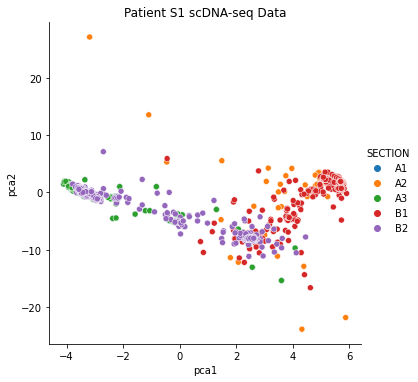

In [9]:
sns.relplot(x = 'pca1', y = 'pca2', hue='SECTION', data=pca_result).set(title='Patient S1 scDNA-seq Data')
